In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import tensorflow as tf

knots = np.linspace(0,10,21)
knots = np.concatenate([np.repeat(knots[0], 3), knots, np.repeat(knots[-1], 3)])
print(knots)


[ 0.   0.   0.   0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.
  5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.  10.  10. ]


## B Splines

In [2]:
def B3_params(u, i):

    D0 = (u[i+1] - u[i]) * (u[i+2] - u[i]) * (u[i+3] - u[i])
    S0 = (u[i], u[i+1])
    if D0 == 0:
        P0 = ([0, 0, 0, 0], S0)
    else:
        C03 = 1/D0
        C02 = 1/D0 * -3 * u[i]
        C01 = 1/D0 * 3 * u[i]**2
        C00 = 1/D0 * -u[i]**3
        P0 = ([C00, C01, C02, C03], S0)


    
    D1 = (u[i+2] - u[i]) * (u[i+2] - u[i+1]) * (u[i+3] - u[i]) * (u[i+3] - u[i+1]) * (u[i+4] - u[i+1])
    S1 = (u[i+1], u[i+2])
    if D1 == 0:
        P1 = ([0, 0, 0, 0], S1)
    else:
        C13 =  - 1/D1 * ( ((u[i+3] - u[i+1]) * (u[i+4] - u[i+1])) + ((u[i+2] - u[i]) * (u[i+4] - u[i+1])) + ((u[i+3] - u[i]) * (u[i+2] - u[i])) )
        C12 = 1/D1 * ( (((u[i+3] - u[i+1]) * (u[i+4] - u[i+1])) * (2*u[i] + u[i+2])) + (((u[i+2] - u[i]) * (u[i+4] - u[i+1])) * (u[i] + u[i+1] + u[i+3])) + (((u[i+3] - u[i]) * (u[i+2] - u[i])) * (2*u[i+1] + u[i+4]) ))
        C11 = - 1/D1 * ( (((u[i+3] - u[i+1]) * (u[i+4] - u[i+1])) * (u[i]**2 + 2*u[i]*u[i+2])) + (((u[i+2] - u[i]) * (u[i+4] - u[i+1])) * (u[i]*u[i+1] + u[i]*u[i+3] + u[i+1]*u[i+3])) + (((u[i+3] - u[i]) * (u[i+2] - u[i])) * (u[i+1]**2 + 2*u[i+1]*u[i+4])))
        C10 =  1/D1 * ( ((u[i+3] - u[i+1]) * (u[i+4] - u[i+1]) * u[i]**2 * u[i+2]) + ((u[i+2] - u[i]) * (u[i+4] - u[i+1]) * u[i] * u[i+1] * u[i+3]) + ((u[i+3] - u[i]) * (u[i+2] - u[i]) * u[i+1]**2 * u[i+4]) )
        P1 = ([C10, C11, C12, C13], S1)

    D2 = (u[i+3] - u[i]) * (u[i+3] - u[i+1]) * (u[i+3] - u[i+2]) * (u[i+4] - u[i+1]) * (u[i+4] - u[i+2])
    S2 = (u[i+2], u[i+3])
    if D2 == 0:
        P2 = ([0, 0, 0, 0], S2)
    else:
        C23 = 1/D2 * (((u[i+4] - u[i+1]) * (u[i+4] - u[i+2])) + ((u[i+3] - u[i]) * (u[i+4] - u[i+2])) + ((u[i+3] - u[i]) * (u[i+3] - u[i+1])))
        C22 = -1/D2 * (((u[i+4] - u[i+1]) * (u[i+4] - u[i+2]) * (u[i] + 2*u[i+3])) + ((u[i+3] - u[i]) * (u[i+4] - u[i+2]) * (u[i+1] + u[i+3] + u[i+4])) + ((u[i+3] - u[i]) * (u[i+3] - u[i+1]) * (u[i+2] + 2*u[i+4])))
        C21 = 1/D2 * (((u[i+4] - u[i+1]) * (u[i+4] - u[i+2]) * (u[i+3]**2 + 2*u[i]*u[i+3])) + ((u[i+3] - u[i]) * (u[i+4] - u[i+2]) * (u[i+1]*u[i+4] + u[i+1]*u[i+3] + u[i+3]*u[i+4])) + ((u[i+3] - u[i]) * (u[i+3] - u[i+1]) * (2*u[i+2]*u[i+4] + u[i+4]**2)))
        C20 = -1/D2 * (((u[i+4] - u[i+1]) * (u[i+4] - u[i+2]) * (u[i]*u[i+3]**2)) + ((u[i+3] - u[i]) * (u[i+4] - u[i+2]) * (u[i+1]*u[i+3]*u[i+4])) + ((u[i+3] - u[i]) * (u[i+3] - u[i+1]) * (u[i+2]*u[i+4]**2)))
        P2 = ([C20, C21, C22, C23], S2)

    D3 = (u[i+4] - u[i+1]) * (u[i+4] - u[i+2]) * (u[i+4] - u[i+3])
    S3 = (u[i+3], u[i+4])
    if D3 == 0:
        P3 = ([0, 0, 0, 0], S3)
    else:
        C33 = 1/D3 * -1
        C32 = 1/D3 * 3 * u[i+4]
        C31 = 1/D3 * -3 * u[i+4]**2
        C30 = 1/D3 * u[i+4]**3
        P3 = ([C30, C31, C32, C33], S3)

    params = [P0, P1, P2, P3]

    return params

def grad_B3_params(u, i):
    P = B3_params(u, i)
    P_dash = []
    for i in range(4):
        P_dash.append(([P[i][0][1], 2*P[i][0][2], 3*P[i][0][3], 0], P[i][1]))
    return P_dash

def grad_grad_B3_params(u, i):
    P = B3_params(u, i)
    P_dash_dash = []
    for i in range(4):
        P_dash_dash.append(([2*P[i][0][2], 6*P[i][0][3], 0, 0], P[i][1]))
    return P_dash_dash  


## Products

In [3]:
def __param_product(p1, p2):

    C0 = p1[0]*p2[0]
    C1 = p1[0]*p2[1] + p1[1]*p2[0]
    C2 = p1[0]*p2[2] + p1[1]*p2[1] + p1[2]*p2[0]
    C3 = p1[0]*p2[3] + p1[1]*p2[2] + p1[2]*p2[1] + p1[3]*p2[0]
    C4 = p1[1]*p2[3] + p1[2]*p2[2] + p1[3]*p2[1]
    C5 = p1[2]*p2[3] + p1[3]*p2[2]
    C6 = p1[3]*p2[3]

    return [C0, C1, C2, C3, C4, C5, C6]

def B3_product(knots, i, j):

    params_1 = B3_params(knots, i)
    params_2 = B3_params(knots, j)

    # idx_1 = np.where(knots == params_1[-1][1][1])[0][0]
    # idx_2 = np.where(knots == params_2[-1][1][1])[0][0]
    # offset = idx_2 - idx_1

    offset = j-i

    if abs(offset) > 3:
        return 0
    else:
        product = []
        for i in range(4 - abs(int(offset))):
            if offset < 0:
                p1 = params_1[i][0]
                p2 = params_2[i-int(offset)][0]
                s = params_1[i][1]
            else:
                p1 = params_1[i + int(offset)][0]
                p2 = params_2[i][0]
                s = params_2[i][1]
            product.append((__param_product(p1, p2), s))

        return product

def grad_B3_product(knots, i, j):
    
    params_1 = grad_B3_params(knots, i)
    params_2 = grad_B3_params(knots, j)
    offset = j-i
    if abs(offset) > 3:
        return 0
    else:
        product = []
        for i in range(4 - abs(int(offset))):
            if offset < 0:
                p1 = params_1[i][0]
                p2 = params_2[i-int(offset)][0]
                s = params_1[i][1]
            else:
                p1 = params_1[i + int(offset)][0]
                p2 = params_2[i][0]
                s = params_2[i][1]
            product.append((__param_product(p1, p2), s))

        return product
    

## Integration

In [4]:
def param_integrate(params):

    if params == 0:
        return 0

    else:

        integral = 0

        for param in params:
            a = param[1][0]
            b = param[1][1]

            i_constants = [1/x for x in range(1, len(param[0])+1)]
            i_param = [0] + [a*b for a,b in zip(i_constants,param[0])]

            a_p = [a**i for i, a in enumerate([a]*len(i_param))]
            b_p = [b**i for i, b in enumerate([b]*len(i_param))]

            d = [b-a for a,b in zip(a_p, b_p)]

            integral += sum(i*d for i,d in zip(i_param, d))

        return integral




## Gram Matrix

In [5]:
def RKHS_IP(knots, i, j, l, sigma):

    p = B3_product(knots, i, j)
    p_dash = grad_B3_product(knots, i, j)

    integral = param_integrate(p)
    integral_dash = param_integrate(p_dash)

    term_1 = l/(2*sigma**2) * integral_dash
    term_2 = 1/(2*l*sigma**2) * integral

    return term_1 + term_2

def Gram_Matrix(knots, l, sigma):

    GM = np.zeros((len(knots)-1-3, len(knots)-1-3))

    for i in range(len(knots)-1-3):
        for j in range(len(knots)-1-3):
            GM[i,j] = RKHS_IP(knots, i, j, l=1, sigma=1)
    return GM

In [6]:
from scipy.sparse import diags

def Gram_Matrix_new(knots, l, sigma):
    elements = []
    for i in range(7):
        elements.append(RKHS_IP(knots, i, 3, l=l, sigma=sigma))
    Kuu_sparse = diags(elements, [-3, -2, -1, 0, 1, 2, 3], shape=(len(knots)-1-3, len(knots)-1-3))
    return Kuu_sparse

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))




In [7]:
knots = np.linspace(-2,2,1000)
GM_sparse_matrix = Gram_Matrix_new(knots, l=1, sigma=1)
GM_sparse_tensor = convert_sparse_matrix_to_sparse_tensor(GM_sparse_matrix)
GM_tensor = tf.sparse.to_dense(GM_sparse_tensor)

print(GM_tensor)


tf.Tensor(
[[ 79.32617188 -13.3203125  -24.98925781 ...   0.           0.
    0.        ]
 [-13.88476562  79.32617188 -13.3203125  ...   0.           0.
    0.        ]
 [-24.42822266 -13.88476562  79.32617188 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  79.32617188 -13.3203125
  -24.98925781]
 [  0.           0.           0.         ... -13.88476562  79.32617188
  -13.3203125 ]
 [  0.           0.           0.         ... -24.42822266 -13.88476562
   79.32617188]], shape=(996, 996), dtype=float64)


2022-02-08 15:38:18.973153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 15:38:19.003252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 15:38:19.003449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 15:38:19.004165: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Plotting

In [8]:
def function_values(params):

    X = []
    F = []

    for i in range(len(params)):
        x = np.linspace(params[i][1][0], params[i][1][1], 50)
        X.append(x)
        f = []
        for j in range(len(params[0][0])):
            f.append(params[i][0][j] * x**j)
        F.append(sum(f))

    return np.concatenate(X).ravel(), np.concatenate(F).ravel()

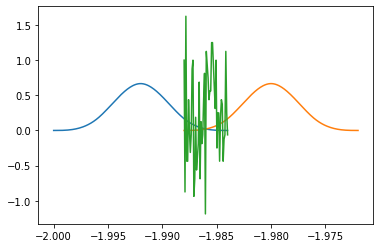

In [9]:
i = 0
j = 3

x0, B0 = function_values(B3_params(knots, i))
x1, B1 = function_values(B3_params(knots, j))
xp, Bp = function_values(B3_product(knots, i, j))

plt.plot(x0, B0)
plt.plot(x1, B1)
plt.plot(xp, Bp)


In [10]:
integral = integrate.trapezoid(Bp, xp)
print(integral)

0.0008963044677330959


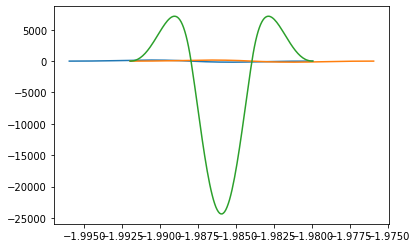

In [11]:
i = 1
j = 2

x0, B0 = function_values(grad_B3_params(knots, i))
x1, B1 = function_values(grad_B3_params(knots, j))
xp, Bp = function_values(grad_B3_product(knots, i, j))

plt.plot(x0, B0)
plt.plot(x1, B1)
plt.plot(xp, Bp)

In [12]:
integral = integrate.trapezoid(Bp, xp)
print(integral)

-31.2484933913507


## 2D B-Splines

In [13]:
def __is_in_support(params, x):
    if x > params[0][1][0] and x <= params[-1][1][1]:
        return True

def __which_peicewise_polynomial(params, x):
    for i in range(len(params)):
        if x > params[i][1][0] and x <= params[i][1][1]:
            return i

def Matern12_Kuf(knots, l, sigma, X):

    Kuf = np.zeros((len(knots)-1-3, len(X)))

    # Loop over basis functions
    for i in range(len(knots)-1-3):
        params = B3_params(knots, i)

        # Loop over data
        for j, x in enumerate(X):

            # Check to see if datapoint is within support of basis function
            if __is_in_support(params, x):
                p = __which_peicewise_polynomial(params, x)

                # Evaluate basis function at x
                f = 0 
                for k in range(len(params[p][0])):
                    f += params[p][0][k] * x**k

                Kuf[i,j] = f

            else:
                Kuf[i,j] = 0

    return tf.convert_to_tensor(Kuf)

In [96]:
from bisect import bisect

def __evaluate_basis_function(knots, B, x, i):
    params = B3_params(knots, B)[i]

    if x>params[1][0] and x<params[1][1]:
        f = 0
        for i, p in enumerate(params[0]):
            f += p * x**i
        return f
    else:
        print('SUPPORTS DO NOT MATCH')


def Matern12_Kuf_new(knots, l, sigma, X):
    Kuf = np.zeros((len(knots)-4, len(X)))
    for j, x in enumerate(X):
        i0 = bisect(knots, x)
        # i = parameter index, B = Basis function index
        for i, B in enumerate(np.arange(max(0, i0-4), i0)[::-1]):
            if B < 7:
                Kuf[B, j] = __evaluate_basis_function(knots, B, x, i)
    return tf.convert_to_tensor(Kuf)


        

In [100]:
import BSplines

X = np.linspace(-1.9, 1.9, 6000)
knots = np.linspace(-3,3,3000)
Kuf = BSplines.Matern12_Kuf(knots, X)

print(Kuf)

ModuleNotFoundError: No module named 'BSplines'

In [5]:
for i in range(0,1):
    print(i)

0
